# Code Generating Netlist of Analog Circuit Programmatically Via PySpice

In [2]:
from PySpice.Spice.Netlist import Circuit, SubCircuitFactory
from PySpice.Unit import u_V, u_mV, u_ps, u_ns, u_us, u_ms, u_Ohm, u_kOhm, u_GOhm, u_uF, u_uA, u_pF, u_A, u_s
import matplotlib.pyplot as plt
import torch
from torch import nn
import tqdm, logging
from IPython.display import clear_output
import numpy as np

# silence xyce warnings
logging.basicConfig(filename='pyspice_warnings.log', level=logging.WARNING, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
pyspice_logger = logging.getLogger('PySpice')
pyspice_logger.setLevel(logging.WARNING)


# Synapse: performing a nonlinear analog "multiplication" between weights (MEM) and currents (RIN)
class Synapse(SubCircuitFactory):
    def __init__(self, cap, scale_synapse=1):
        self.NAME = f'synapse'
        self.NODES = ('WWL', 'WBL', 'RINP', 'RINN', 'ROUT', 'REF', 'REF2')
        super().__init__()
        self.S('write', 'MEM', 'WBL', 'WWL', self.gnd, model='switch')
        self.C('cap', 'MEM', '0', cap, model='capacitor')
        self.X('pfet',  'sky130_fd_pr__pfet_01v8', 'DRAIN', 'MEM', 'DD', 'DD', l=0.15, w=0.42*3.1, M=scale_synapse)
        self.X('nfet',  'sky130_fd_pr__nfet_01v8', 'DRAIN', 'MEM', 'SS', 'SS', l=0.15, w=0.42, M=scale_synapse)
        self.R('drain', 'DRAIN', 'ROUT', 0@u_Ohm)
        self.R('DD', 'RINP', 'DD', 0@u_Ohm)
        self.R('SS', 'RINN', 'SS', 0@u_Ohm)
        self.R('ref', 'REF', 'ROUT', 0@u_Ohm)
        self.R('ref2', 'REF2', 'DD', 0@u_Ohm)

# Amplifier: a (linear) activation function between layers, amplifying voltages forward and currents backward
class Amplifier(SubCircuitFactory):
    def __init__(self, name, v_gain, lower=None, upper=None, Vth=0.65):
        self.NAME = name
        self.NODES = ('IN', 'OUTP', 'OUTN')
        super().__init__()
        self.R('p', 'OUTP', 'OUTPR', 10@u_Ohm)
        self.B('vcvsp', 'OUTPR', self.gnd, voltage_expression=f'{{{v_gain} * V(IN)}}')
        self.B('cccs', 'IN', self.gnd, current_expression=f'{{{-1/v_gain} * (I(Bvcvsp) - I(Bvcvsn))}}')
        self.B('vcvsn', 'OUTNR', self.gnd, voltage_expression=f'{{{-v_gain} * V(IN)}}')
        self.R('n', 'OUTN', 'OUTNR', 10@u_Ohm)
        if lower is not None:
            self.D('diolp', 'LOWER', 'OUTPR', model='diode_ideal')
            self.D('dioln', 'OUTNR', 'LOWER', model='diode_ideal')
            self.V('lower', 'LOWER', self.gnd, lower@u_V)
        if upper is not None:
            self.D('dioup', 'OUTPR', 'UPPER', model='diode_ideal')
            self.D('dioun', 'UPPER', 'OUTNR', model='diode_ideal')
            self.V('upper', 'UPPER', self.gnd, upper@u_V)

# Optimizer: measures Vg during NUDGED phase, clamps it during FREE phase
class Optimizer(SubCircuitFactory):
    def __init__(self, cap, scale_update=1, lower=-0.9, upper=0.9):
        self.NAME = 'optimizer'
        self.NODES = ['WBL', 'FREE', 'NUDGED', 'NUDGED_OUTER', 'NUDGED_EARLY', 'UPDATE', 'REF', 'REF2']
        super().__init__()
        # store REF during FREE phase
        self.B('free', 'VFREE', self.gnd, voltage_expression=f'{{V(REF)}}')
        self.S('free', 'VFREE', 'REFFREE', 'FREE', self.gnd, model='switch')
        self.C('free', 'REFFREE', '0', cap, model='capacitor')
        
        # compute and store target value during NUDGED phase
        self.B('diffamp', 'TARGET', self.gnd, voltage_expression=f'{{(V(WBL)-{scale_update}*(V(REF)-V(REFFREE)) * V(REF2) ) * V(NUDGED_OUTER)/1.95}}')
        self.S('nudge', 'TARGET', 'STORE', 'NUDGED_EARLY', self.gnd, model='switch') # store target value during nudged phase
        self.C('store', 'STORE', '0', cap, model='capacitor')
        
        # apply update during UPDATE phase
        self.B('update', 'VSTORE', self.gnd, voltage_expression=f'{{V(STORE)}}')
        self.S('update','WBL', 'VSTORE', 'UPDATE', self.gnd, model='switch') # apply update to WBL


class Crossbar(SubCircuitFactory):
    def __init__(self, name, W, row_to_update, scale_update=1, scale_synapse=1, t=False, max_rows=8, cap=0.1@u_pF, t_period=1600@u_ns, t_change=40@u_ns, t_offset=160@u_ns):
        self.NAME = name
        self.NODES = ["FREE", "NUDGED", "NUDGED_OUTER", "NUDGED_EARLY", "UPDATE"]
        self.NODES += [f"RINP_{i}" for i in range(W.shape[0])] + [f"RINN_{i}" for i in range(W.shape[0])] + [f"ROUT_{j}" for j in range(W.shape[1])]
        super().__init__()
        rows, cols = W.T.shape if t else W.shape # weights in the same 'row' will be set/updated in parallel
        assert rows <= max_rows, f"max_rows={max_rows}<=rows={rows} assumption violated" # max_rows must be equal in all layers to sync timing
        self.subcircuit(Synapse(cap=cap*scale_synapse, scale_synapse=scale_synapse))
        self.subcircuit(Optimizer(cap=cap, scale_update=scale_update))
        
        # Setup Circuit
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                row, col = (j, i) if t else (i, j)
                self.X(f'W_I{i}_J{j}', f'synapse', f'WWL_{row}', f'WBL_{col}', f'RINP_{i}', f'RINN_{i}', f'ROUT_{j}', f'REF_I{i}_J{j}', f'REF2_I{i}_J{j}')
                self.S(f'REF_I{i}_J{j}', f'REF_{col}', f'REF_I{i}_J{j}', f'WWL_{row}', self.gnd, model='switch') # forwards the right source to the optimizer
                self.S(f'REF2_I{i}_J{j}', f'REF2_{col}', f'REF2_I{i}_J{j}', f'WWL_{row}', self.gnd, model='switch') # forwards the right source to the optimizer
    
        for col in range(cols):
            self.X(f'opt_{col}', 'optimizer', f'WBL_{col}', 'FREE', 'NUDGED', 'NUDGED_OUTER', 'NUDGED_EARLY', 'UPDATE', f'REF_{col}', f'REF2_{col}')
        for j in range(W.shape[1]):
            self.S(f'GND_{j}', f'ROUT_{j}', self.gnd, 'SET', self.gnd, model='switch') # ensures capacitors are grounded during weight setting

        # Set Weights: t_period = (t_change + t_width) * 2  = /---\___
        t_width = (t_period - 2 * t_change)/2
        wwl_times, wwl_values = [], []
        for row in range(rows):
            wwl_times.append([0@u_ns, t_period*(row+1), t_period*(row+1)+t_change,
                t_period*(row+1)+t_change+t_width, t_period*(row+1)+2*t_change+t_width])
            wwl_values.append([0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V])
        
        for col in range(cols):
            times, values  = [0@u_ns], [0@u_V]
            for row in range(rows):
                    i, j  = (col, row) if t else (row, col)
                    times += [t_period*(row+1)-t_offset, t_period*(row+1)-t_offset+t_change,
                              t_period*(row+1)+t_offset+t_change+t_width, t_period*(row+1)+t_offset+2*t_change+t_width]
                    values += [0@u_V, W[i, j].item()@u_V, W[i, j].item()@u_V, 0@u_V]
            self.PieceWiseLinearVoltageSource(f'SET_{col}', f'SET_{col}', self.gnd, values=zip(times, values))
            self.S(f'SET_{col}', f'SET_{col}', f'WBL_{col}', 'SET', self.gnd, model='switch')

        times  = [0@u_ns, (max_rows+1) * t_period, (max_rows+1) * t_period + t_change]
        self.PieceWiseLinearVoltageSource(f'SET', f'SET', self.gnd, values=zip(times, [1.95@u_V, 1.95@u_V, 0@u_V]))

        # Update Weights
        for row in range(rows):
            wwl_values[row] += [0@u_V]
            wwl_times[row]  += [(max_rows+2) * t_period]
            for i, update in enumerate(row_to_update):
                for p, phase in enumerate(['FREE', 'NUDGED', 'UPDATE']):
                    start = (max_rows+2 + i*3 + p) * t_period + t_width
                    startoff, endoff = (+t_offset, -t_offset) if phase=='UPDATE' else (-t_offset, +t_offset)
                    wwl_times[row]  += [start+startoff, start+t_change+startoff, start+t_width+t_change+endoff, start+t_width+t_change*2+endoff]
                wwl_values[row] += [0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V] * 3 if row == update else [0@u_V]*12
            self.PieceWiseLinearVoltageSource(f'WWL_{row}', f'WWL_{row}', '0', values=zip(wwl_times[row], wwl_values[row]))


class MSELoss(SubCircuitFactory):
    def __init__(self, dY, lr, cap):
        self.NAME = 'loss'
        self.NODES  = ['FREE', 'NUDGED']
        self.NODES += [f"Y_{i}"  for i in range(dY)] + [f"PRED_{i}" for i in range(dY)]
        super().__init__()
        LOSS = ""
        for i in range(dY):
            self.S(f'PRED_{i}_FREE', f'PRED_{i}', f'PRED_{i}_FREE', 'FREE', self.gnd, model='switch')
            self.C(f'PRED_{i}_FREE', f'PRED_{i}_FREE', self.gnd, cap, model='capacitor')
            self.S(f'PRED_{i}_NUDGED', f'PRED_{i}', f'PRED_{i}_NUDGED', 'NUDGED', self.gnd, model='switch')
            self.R(f"NUDGE_{i}", f"PRED_{i}_NUDGED", f"NUDGE_{i}", (1/lr)@u_Ohm)
            self.B(f"NUDGE_{i}", f"NUDGE_{i}", self.gnd, voltage_expression=f"{{V(Y_{i})}}")
            #self.B(f"NUDGE_{i}", f"PRED_{i}", self.gnd, current_expression=f"{{{lr} * (V(PRED_{i}_FREE) - V(Y_{i})) * V(NUDGED) / 10}}")
            self.R(f"GND_{i}", f"PRED_{i}", self.gnd, 10000@u_Ohm)
            LOSS += f"+ ( V(Y_{i}) - V(PRED_{i}) )**2"
        self.B("LOSS", "LOSS", self.gnd, voltage_expression=f"{{{LOSS[1:]}}}")


class MLP(SubCircuitFactory):
    def __init__(self, weights, X, Y, rows_to_update, lr, v_gain, cap=0.1@u_pF, step_time=100@u_ns, min_act=0.0, max_act=None):
        self.NAME   = 'mlp' 
        self.NODES = ['NUDGED', 'FREE', 'UPDATE']
        self.NODES += [f'X_{i}' for i in range(X.shape[1])]
        self.NODES += [f'Y_{j}_{phase}' for j in range(Y.shape[1]) for phase in ["NUDGED"]]
        super().__init__()
        self.model('switch',  'VSWITCH', VON=0.5@u_V, VOFF=0.4@u_V, ROFF=1e11@u_kOhm, RON=0.0001@u_Ohm)
        self.model('diode', 'D')
        self.model('diode_ideal', 'D', Ron=0.0001@u_Ohm, Roff=100@u_GOhm, Vfwd=0@u_V)
        self.model('capacitor', 'C')
        self.subcircuit(Amplifier('linear', v_gain))
        self.subcircuit(Amplifier('nonlinear', v_gain, lower=min_act, upper=max_act))

        self.step_time = step_time
        t_period = 40*step_time
        t_change = 2*step_time
        t_offset = 4*step_time
        max_rows = max(min(W.shape) for W in weights)
        for L, (W, row_to_update) in enumerate(zip(weights, rows_to_update.T)):
            scale_update = [20, 3][L]  # scales update strength
            scale_synapse = [1, W.shape[0]//W.shape[1]][L] # scales number of synapses per weight
            t = (W.shape[0]>W.shape[1])  # maximizes how many weights can be updated at once by transposing crossbar update circuit
            self.subcircuit(Crossbar(f'crossbar_L{L}', W, row_to_update, scale_update, scale_synapse, t, max_rows, cap, t_period, t_change, t_offset))
        self.subcircuit(MSELoss(Y.shape[1], lr, cap))

        
        for L, (i, o) in enumerate(zip((X, *weights), (*weights, Y.T))):
            assert i.shape[1] == o.shape[0], f'shape mismatch {i.shape[1]}!={o.shape[0]} in layer {L}, check tensor shapes'
        
        for L, W in enumerate(weights):
            self.X(f'layer_L{L}', f'crossbar_L{L}', 'FREE', 'NUDGED', 'NUDGED_OUTER', 'NUDGED_EARLY', 'UPDATE',
                *(f'postactp_L{L}_I{i}' for i in range(W.shape[0])),
                *(f'postactn_L{L}_I{i}' for i in range(W.shape[0])),
                *(f'preact_L{L+1}_I{i}' for i in range(W.shape[1]))
            )

            for i in range(W.shape[1]):
                act = 'linear' if (L==len(weights)-1) else 'nonlinear' # linear activation for output layer
                self.X(f'act_L{L+1}_I{i}', act, f'preact_L{L+1}_I{i}', f'postactp_L{L+1}_I{i}', f'postactn_L{L+1}_I{i}')

        self.X('loss', 'loss', 'FREE', 'NUDGED_OUTER',
                *(f'Y_{i}' for i in range(Y.shape[1])),
                *(f'postactp_L{L+1}_I{i}' for i in range(W.shape[1]))
        )

        ## Feed data for training
        times = [0@u_ns, (max_rows+2) * t_period]
        times_outer  = [0@u_ns, (max_rows+2) * t_period]
        times_early  = [0@u_ns, (max_rows+2) * t_period]
        t_width = (t_period - 2 * t_change)/2
        xvalues = [[0@u_V, 0@u_V,] for i in range(X.shape[1])]
        yvalues = [[0@u_V, 0@u_V] for i in range(Y.shape[1])]
        nudged  = [0@u_V, 0@u_V,]
        free    = [0@u_V, 0@u_V,]
        update  = [0@u_V, 0@u_V,]
        for i in range(X.shape[0]):
            for phase in ('FREE', 'NUDGED', 'UPDATE'):
                times += [times[-1]+t_width, times[-1]+t_width+t_change, times[-1]+2*t_width+t_change, times[-1]+2*t_width+2*t_change]
                times_outer += [times[-4]-t_offset, times[-3]-t_offset, times[-2]+t_offset, times[-1]+t_offset]
                times_early += [times[-4]-t_offset, times[-3]-t_offset, times[-2]-t_offset, times[-1]-t_offset]
            free   += [0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V] # ___|--|_____________ FREE
            nudged += [0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V] # ________|--|________ NUDGED
            update += [0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 0@u_V, 1.95@u_V, 1.95@u_V, 0@u_V] # _____________|--|___ UPDATE
            for d in range(X.shape[1]):                                                                          # __|---------------|_________ X
                xvalues[d] += ([0@u_V] + [X[i,d].item()@u_V] * 10 + [0@u_V])
            for d in range(Y.shape[1]):
                yvalues[d] += ([0@u_V] + [Y[i,d].item()@u_V] * 10 + [0@u_V])
        
        self.PieceWiseLinearVoltageSource(f'FREE', 'FREE', '0', values=zip(times, free))
        self.PieceWiseLinearVoltageSource(f'NUDGED', 'NUDGED', '0', values=zip(times, nudged))
        self.PieceWiseLinearVoltageSource(f'NUDGED_OUTER', 'NUDGED_OUTER', '0', values=zip(times_outer, nudged))
        self.PieceWiseLinearVoltageSource(f'NUDGED_EARLY', 'NUDGED_EARLY', '0', values=zip(times_early, nudged))
        self.PieceWiseLinearVoltageSource(f'UPDATE', 'UPDATE', '0', values=zip(times, update))

        for i in range(X.shape[1]):
            self.PieceWiseLinearVoltageSource(f'Xp_{i}', f'Xp_{i}', '0', values=zip(times_outer, xvalues[i]))
            self.PieceWiseLinearVoltageSource(f'Xn_{i}', '0', f'Xn_{i}', values=zip(times_outer, xvalues[i]))
            self.R(f'Xp_{i}', f'postactp_L0_I{i}', f'Xp_{i}', 0@u_Ohm)
            self.R(f'Xn_{i}', f'postactn_L0_I{i}', f'Xn_{i}', 0@u_Ohm)
        for i in range(Y.shape[1]):
            self.PieceWiseLinearVoltageSource(f'Y_{i}', f'Y_{i}', '0', values=zip(times_outer, yvalues[i]))
        self.end_time = max(times_outer) * 1.1

# Some Helper Functions

In [8]:
def get(analysis, item): # fixes a bug in pyspice+Xyce where some 0's are renamed to _
    if item in analysis:
        return analysis[item]
    else:
        for _ in analysis.keys():
            if _.replace('0', '_') == item.replace('0', '_'):
                return analysis[_]




def plot_analyses(analyses, dims, initial_weights):
    analysis = dict()
    epoch_times = []
    for node in analyses[0].nodes:
        analysis[node] = np.array(analyses[0][node])
    epoch_times.append(0)
    for a in analyses[1:]:
        for node in a.nodes:
            if node == "time":
                epoch_times.append(analysis[node].max().item())
                analysis[node] = np.concatenate([analysis[node], analysis[node].max()+np.array(a[node])])
            else:
                analysis[node] = np.concatenate([analysis[node], np.array(a[node])])
    epoch_times.append(analysis["time"].max().item())

    x0 = np.array(analysis["XMLP:XP_0"])
    y  = sum([np.array(analysis[f"XMLP:POSTACTP_L{len(dims)-1}_I{i}"]) for i in range(dims[-1])]) / dims[-1]
    nudged = np.array(analysis["NUDGED"])
    free = np.array(analysis["FREE"])
    update = np.array(analysis["UPDATE"])
    loss   = np.array(analysis["XMLP:XLOSS:LOSS"])
    time   = np.array(analysis["time"])
    during_nudged = np.abs(nudged - nudged.max()) < 1e-2
    during_free = np.abs(free-free.max()) < 1e-2
    during_update = np.abs(update-update.max()) < 1e-2
    late = time > epoch_times[-2]
    early = (time < epoch_times[1])

    plt.title(f"Fit (epoch {len(epoch_times)-1})")
    for phase, select in [
            (f"forward (epoch 0)", during_free & early),
            (f"forward (epoch {len(epoch_times)-1})", during_free & late),
            (f"nudged (epoch 0)", during_nudged & early),
            (f"nudged (epoch {len(epoch_times)-1})", during_nudged & late), 
        ]:
        plt.scatter(x0[select], y[select], alpha=0.1, label=phase)
    #plt.ylim(min(Y[:,0].min(), y[during_free & late].min()), max(Y[:,0].max(), y[during_free & late].max()))
    plt.ylim(-0.035, 0.055)
    plt.scatter(X[:,0], Y[:,0], color="red", alpha=0.4, label="target", marker='*')
    plt.legend()
    plt.savefig(f"figures/sine_fit_epoch_{len(epoch_times)-1}.png")
    plt.show()
    plt.plot(time, loss*during_free)
    plt.title(f"Loss (free phase), Epoch {len(epoch_times)-1}")
    plt.savefig(f"figures/loss_epoch_{len(epoch_times)-1}.png")
    plt.show()

    for full_length in [False, True]:
        for l in list(range(len(dims)-1))[::-1]:
            for i, j in [(0,0), (1,0), (2,0), (3,0), (0,1), (1,1), (2,1)]:
                if (j > dims[l+1]-1) or (i > dims[l]-1):
                    continue

                Vg = np.array(get(analysis, f"XMLP:XLAYER_L{l}:XW_I{i}_J{j}:MEM"))
                REF = np.array(analysis[f"XMLP:XLAYER_L{l}:REF_I{i}_J{j}"])
                Vd = np.array(get(analysis, f"XMLP:XLAYER_L{l}:XW_I{i}_J{j}:DRAIN"))
                ACT = np.array(analysis[f"XMLP:POSTACTP_L{l}_I{i}"])
                plt.axhline(initial_weights[l][i,j])
                plt.fill_between(time, y1=0, y2=during_nudged, label="nudged", alpha=0.1)
                plt.fill_between(time, y1=0, y2=during_free, label="free", alpha=0.1)
                plt.fill_between(time, y1=0, y2=during_update, label="update", alpha=0.1)
                plt.plot(time, Vg, label="Weight", color="red")
                ep = len(epoch_times)-2
                start, d = epoch_times[ep], (epoch_times[ep+1]-epoch_times[ep])
                if not full_length:
                    plt.xlim(start - d/n * 4, start + d/n * 12)
                plt.plot(time, Vd-REF, label="I(OUT)", color="green", alpha=0.3)
                plt.plot(time, ACT, label="V(IN)", color="orange", alpha=0.2)
                plt.plot(time, Vd, label="V(OUT)", color="blue", alpha=0.4)
                plt.title(f"L{l}_I{i}_J{j}")
                plt.legend(loc="lower left")
                plt.ylim(-1.0, 1.0)
                plt.savefig(f"figures/weights_L{l}_I{i}_J{j}.png")
                plt.show()



# Training Loop

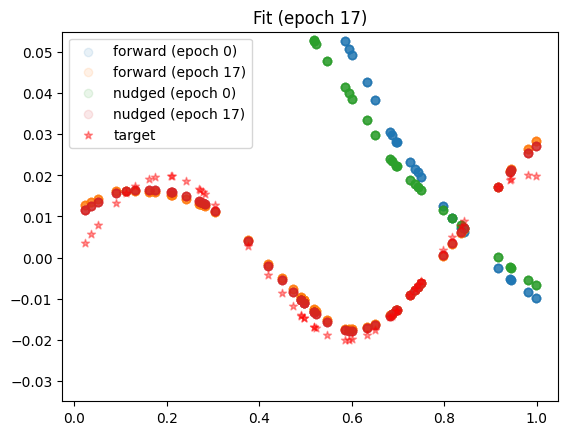

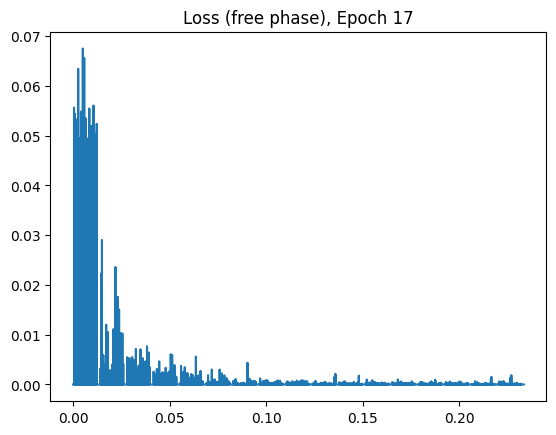

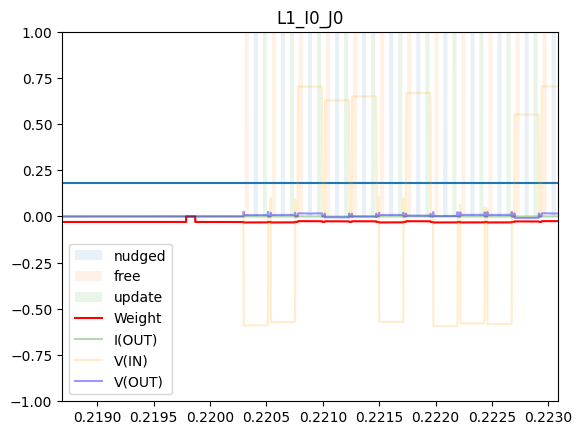

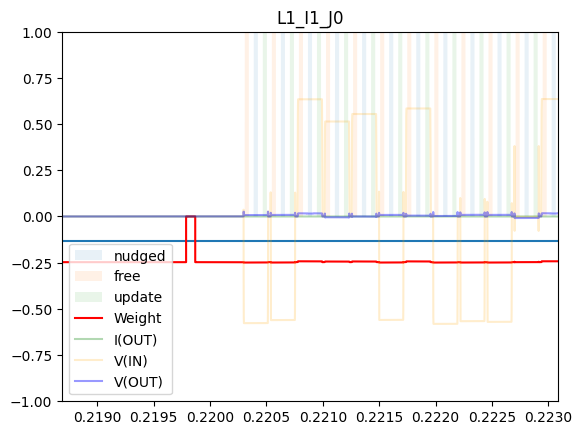

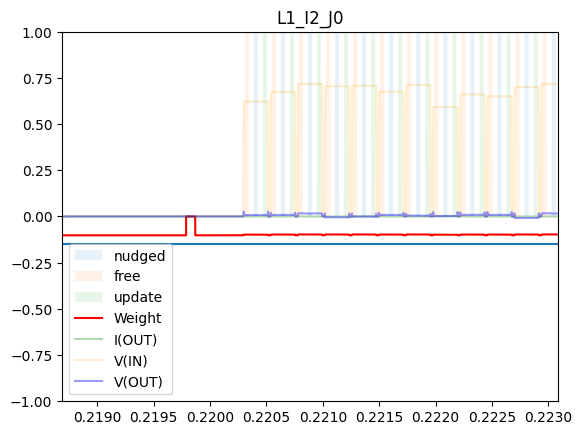

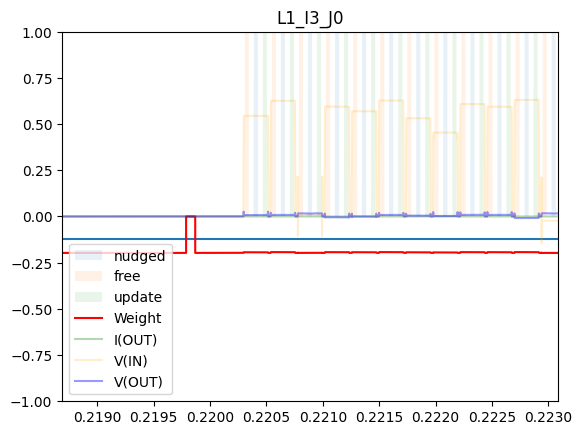

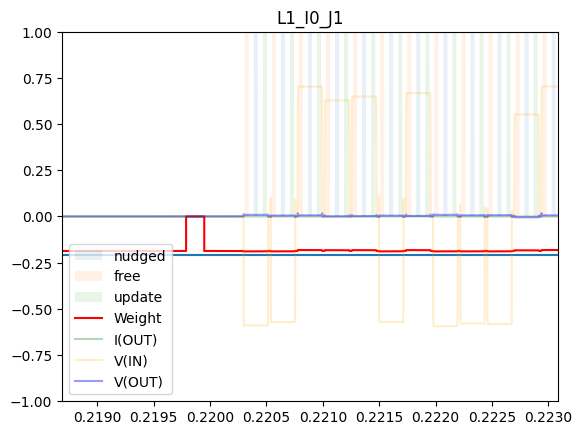

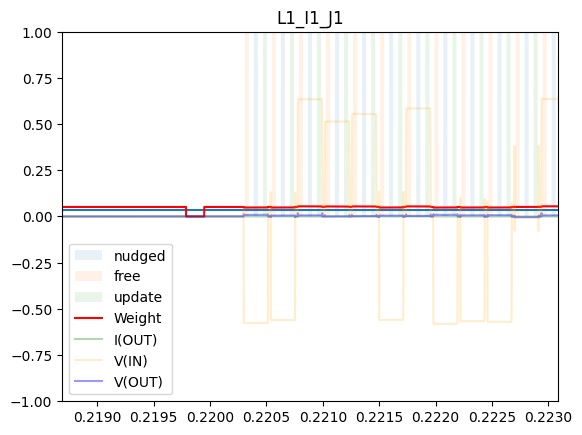

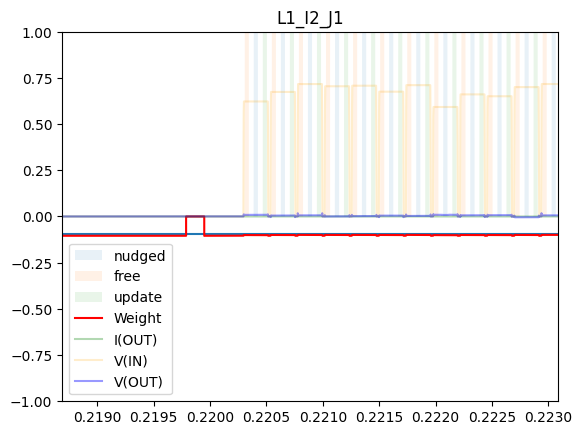

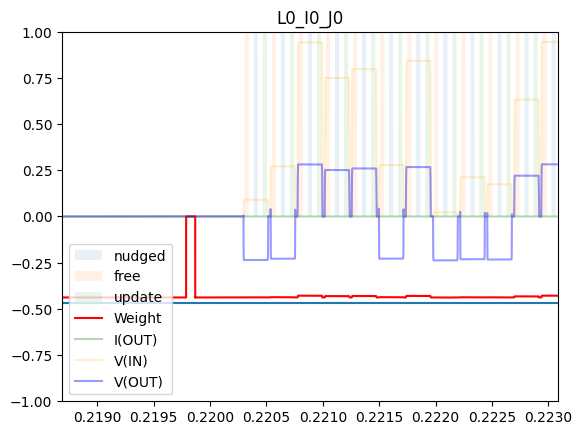

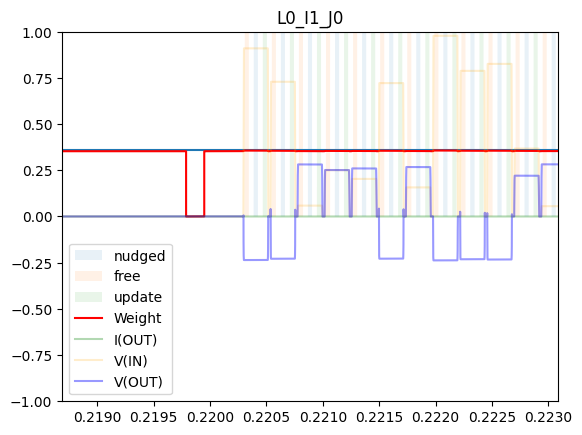

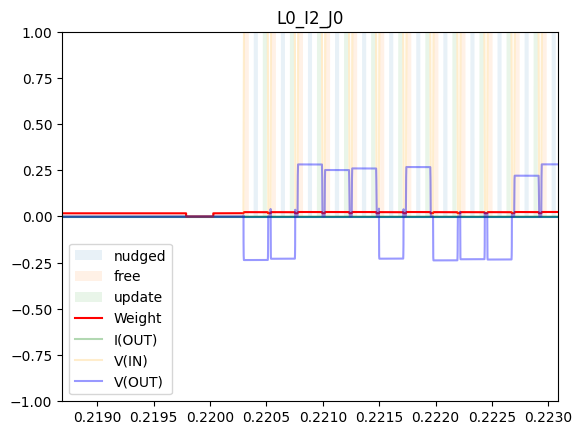

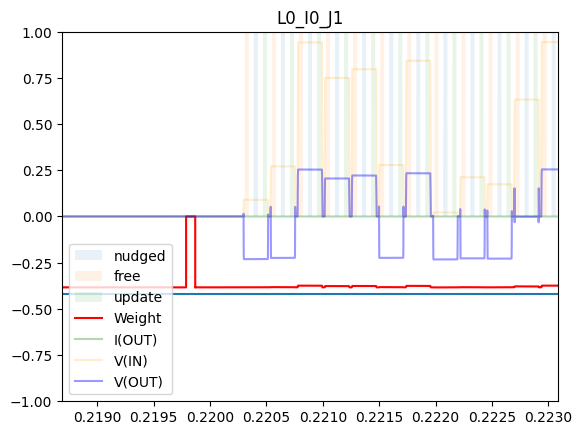

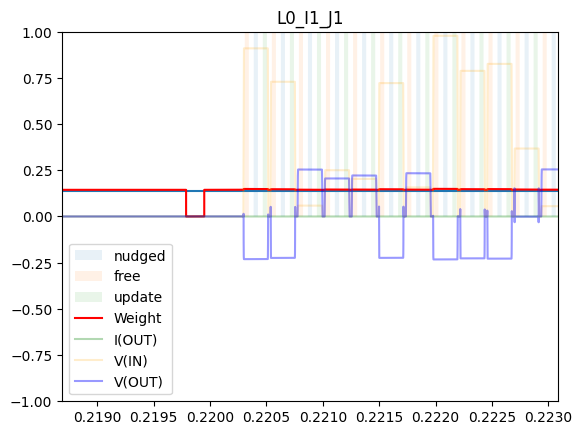

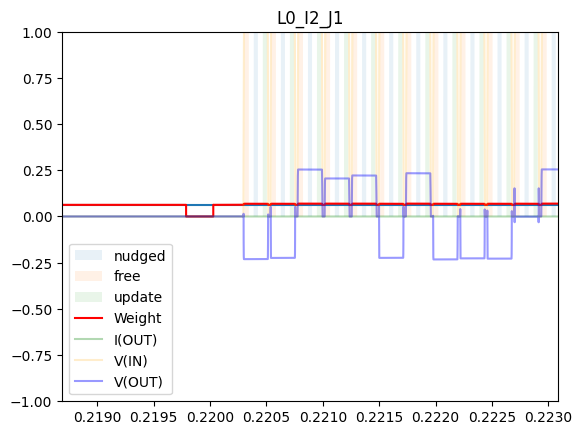

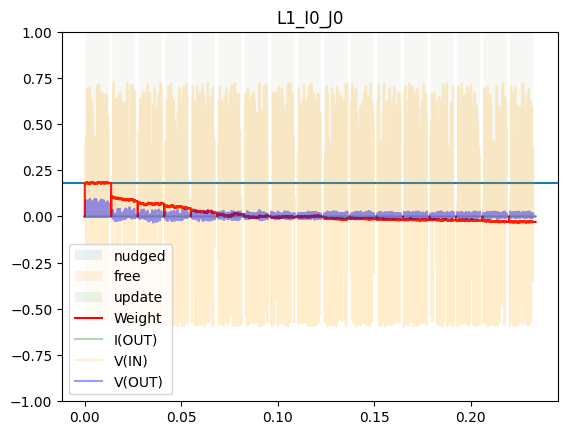

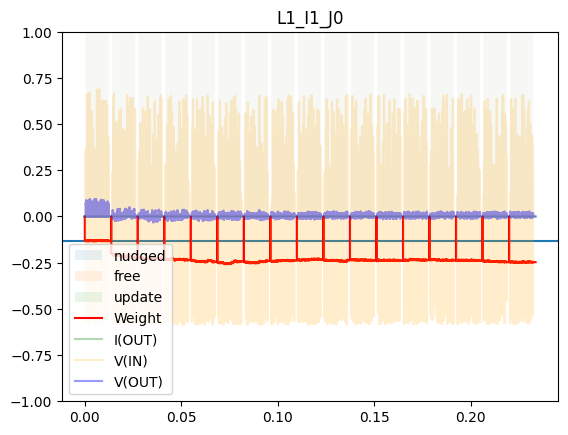

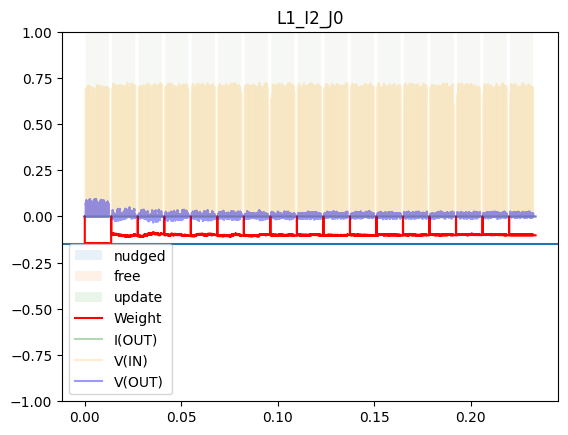

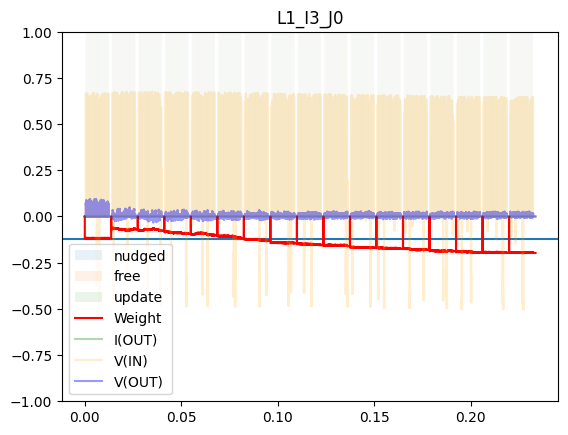

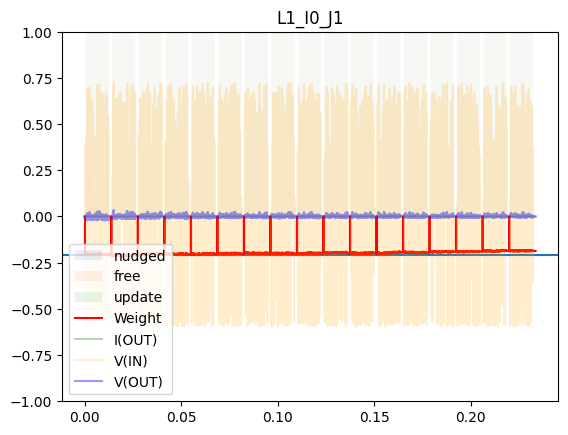

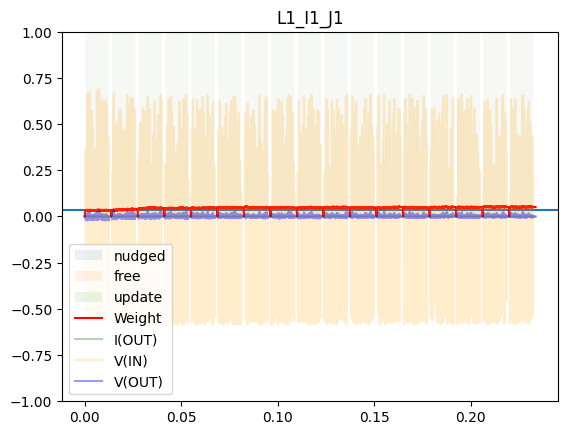

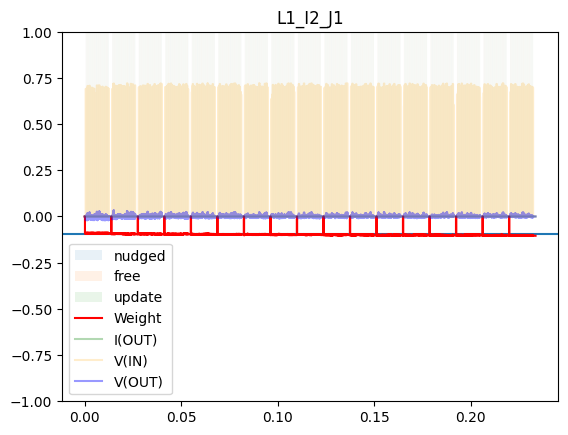

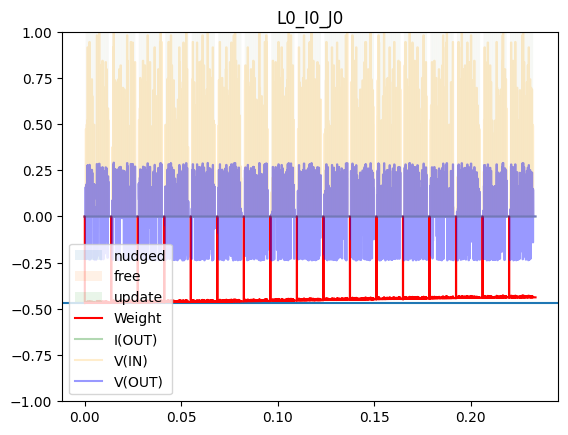

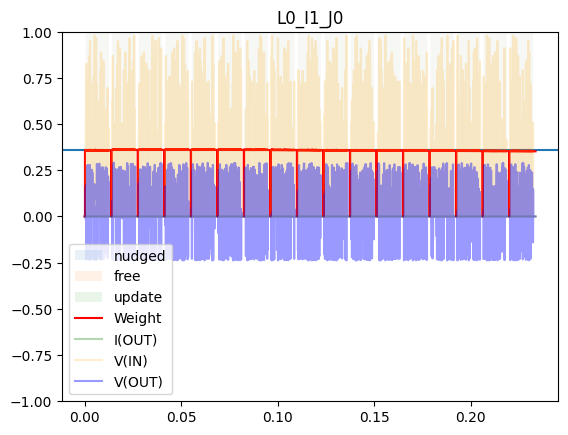

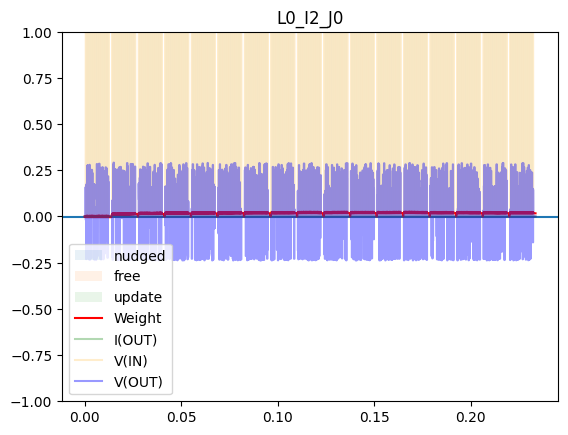

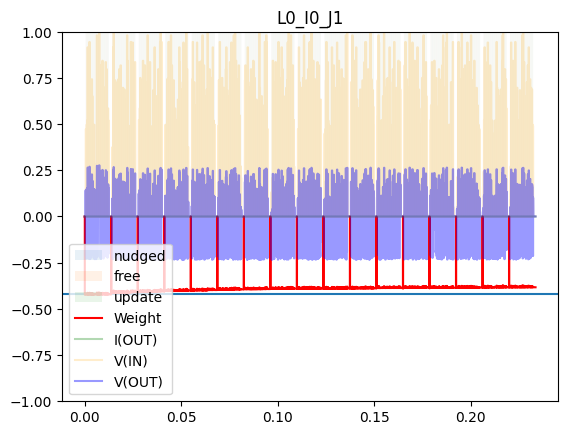

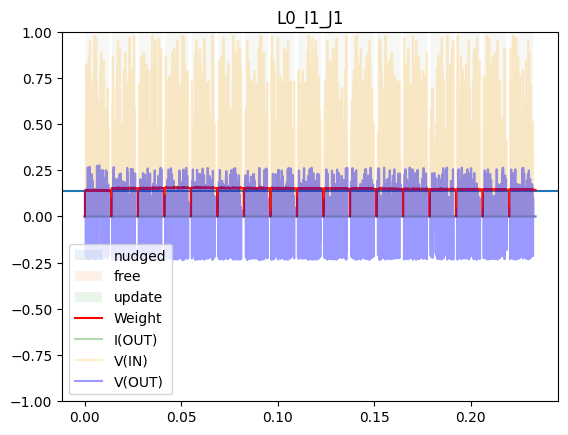

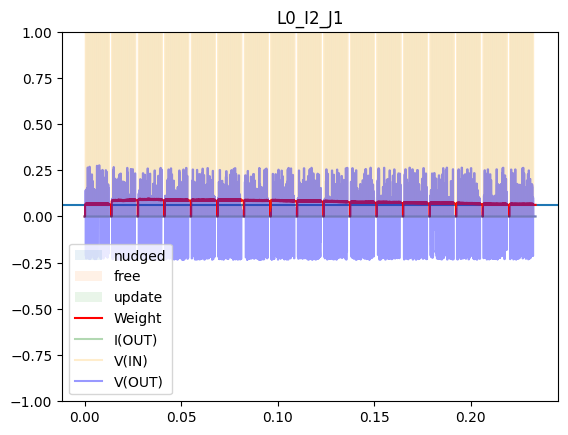

----- saving epoch 31: 100%|██████████| 32/32 [45:54<00:00, 86.09s/it]

done


In [12]:
# initialize data
n = 50
torch.manual_seed(0)
X = torch.rand(n, 3)
X[:,1:2] = 1-X[:, 0:1]
X[:,2:3] = 1
X = torch.cat([X], dim=1)
Y = (X[:,0:1]*8).sin()*0.02#0.005
#Y *= 4.0 # remove 
Y = Y.repeat(1, 4)
X *=  1

# initialize network parameters
dims = [X.shape[1], 32, Y.shape[1]] # input, hidden, output
#weights = [1.5*(torch.rand(d_in, d_out)-0.5)/d_in**0.5  for l, (d_in, d_out) in enumerate(zip(dims[:-1], dims[1:]))] # this used to work well with width 32
weights = [1*(torch.rand(d_in, d_out)-0.5)/(1+l)  for l, (d_in, d_out) in enumerate(zip(dims[:-1], dims[1:]))] # this used to work well
initial_weights = [_.clone() for _ in weights]

# 32 epochs on lr=0.002 then 16 epochs on lr=0.01

# initialize training hyperparameters
epochs = 32
lr = 0.0005 # inverse of nudging resistance (1/Ohm)
v_gain = 2.5 # 1.0 was better

# simulate
print(dims)
analyses = []
try:
    for epoch in (progress := tqdm.tqdm(range(epochs))):
        # some memory management
        !rm -rf /var/tmp
        !rm -rf /tmp/*
        !rm -rf ./tmp*
        !rm -f pyspice_warnings.log
        
        # sample columns to free at each datapoint
        rows_to_update = torch.stack([torch.arange(min(i,o)).repeat(n//min(i,o)+1)[torch.randperm(min(i,o)*(n//min(i,o)+1))][:n] for i, o in zip(dims[:-1], dims[1:])]).T
        if not ((epoch > 0) & (epoch<epochs-1)): 
            print("not updating weights in first and last epoch")
            rows_to_update.fill_(-1)

        # shuffle data
        perm = torch.randperm(n)
        X, Y = X[perm], Y[perm]

        # run transient simulation of current epoch
        progress.set_description(f"--- preparing epoch {epoch}")
        circuit = Circuit('Crossbar Circuit')
        circuit.lib(f'/root/miniforge3/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice', 'tt')
        circuit.subcircuit(mlp := MLP(
            weights, X, Y, rows_to_update, lr, v_gain, step_time=2000@u_ns,
        ))
        circuit.X('mlp', 'mlp', *mlp.NODES)
        simulator = circuit.simulator(simulator="xyce-parallel")
        progress.set_description(f"----- running epoch {epoch}")
        analysis = simulator.transient(step_time=mlp.step_time, end_time=mlp.end_time)
        progress.set_description(f"----- saving epoch {epoch}")
        analyses.append(analysis)

        # set parameter variables to the most recent values
        time = np.array(analysis.time)
        for l in range(len(weights)):
            for i in range(weights[l].shape[0]):
                for j in range(weights[l].shape[1]):
                    weights[l][i, j] = (get(analysis.nodes, f"XMLP:XLAYER_L{l}:XW_I{i}_J{j}:MEM") - get(analysis.nodes, f"XMLP:XLAYER_L{l}:XW_I{i}_J{j}:DRAIN"))[-10:].mean().item()
        
        # plot the current epoch
        clear_output(wait=True)
        plot_analyses(analyses, dims, initial_weights)
        
        # some additional memory management
        if epoch % 2 == 1:
            _ = analyses.pop(-1)
            del _
        del analysis, simulator, circuit
        
        
except KeyboardInterrupt:
    print("Graceful Exit.")

print('done')

# Assemble GIF Visualizing Training Run

In [16]:
sine_images

['figures/sine_fit_epoch_1.png',
 'figures/sine_fit_epoch_10.png',
 'figures/sine_fit_epoch_11.png',
 'figures/sine_fit_epoch_12.png',
 'figures/sine_fit_epoch_13.png',
 'figures/sine_fit_epoch_14.png',
 'figures/sine_fit_epoch_15.png',
 'figures/sine_fit_epoch_16.png',
 'figures/sine_fit_epoch_17.png',
 'figures/sine_fit_epoch_2.png',
 'figures/sine_fit_epoch_3.png',
 'figures/sine_fit_epoch_4.png',
 'figures/sine_fit_epoch_5.png',
 'figures/sine_fit_epoch_6.png',
 'figures/sine_fit_epoch_7.png',
 'figures/sine_fit_epoch_8.png',
 'figures/sine_fit_epoch_9.png']

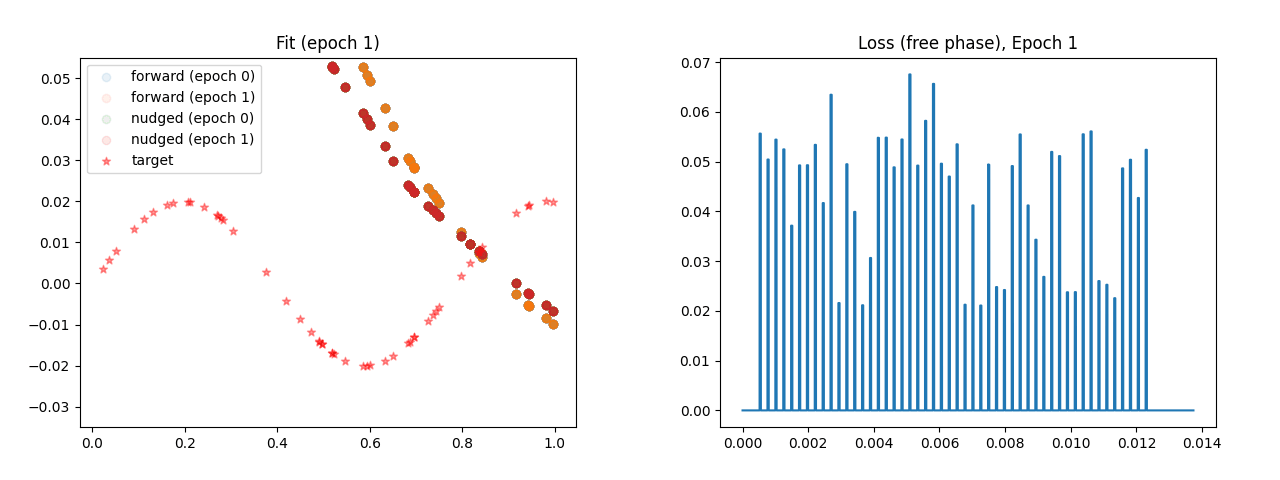

In [18]:
from PIL import Image
import glob

# Create list to store combined images
combined_images = []

# Combine corresponding images side by side
for epoch in range(len(glob.glob('figures/sine_fit_*.png'))):
    # Open images
    sine = Image.open(f"figures/sine_fit_epoch_{epoch+1}.png")
    loss = Image.open(f"figures/loss_epoch_{epoch+1}.png")
    
    # Create new blank image with width = sum of widths, height = max height
    total_width = sine.width + loss.width
    max_height = max(sine.height, loss.height)
    combined = Image.new('RGB', (total_width, max_height))
    
    # Paste images side by side
    combined.paste(sine, (0, 0))
    combined.paste(loss, (sine.width, 0))
    
    combined_images.append(combined)

# Save as animated GIF
combined_images[0].save(
    'figures/training_progress.gif',
    save_all=True,
    append_images=combined_images[1:],
    duration=500,  # Time per frame in milliseconds
    loop=0  # 0 means loop forever
)

# Display the GIF in the notebook
from IPython.display import Image as IPImage
IPImage(filename='figures/training_progress.gif')


# Export Netlist To File, For Reference

In [ ]:
simulator.reset_analysis = lambda *args: args
analysis = simulator.transient(step_time=0.01@u_ns, end_time=0.05@u_us)
with open("netlist.spice", "w") as f: f.write(str(analysis.simulation))
!Xyce -hspice-ext all netlist.spice